In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (OneHotEncoder,OrdinalEncoder,StandardScaler,MinMaxScaler,PowerTransformer,FunctionTransformer)
from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (RareLabelEncoder,MeanEncoder,CountFrequencyEncoder)
import matplotlib.pyplot as plt
import warnings

In [2]:
pd.set_option("display.max_columns", None)
sklearn.set_config(transform_output="pandas")
warnings.filterwarnings("ignore")

In [3]:
path = r"C:\Users\as\OneDrive\Desktop\flight price prediction\data\train.csv"

train = pd.read_csv(path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-03-06,Delhi,Cochin,12:30:00,09:25:00,1255,1.0,No Info,13832
1,Jet Airways,2019-06-06,Delhi,Cochin,15:00:00,04:25:00,805,1.0,In-flight meal not included,10262
2,Air India,2019-05-09,Kolkata,Banglore,16:50:00,07:55:00,905,1.0,No Info,8366
3,Jet Airways,2019-03-21,Banglore,New Delhi,09:45:00,15:55:00,370,1.0,In-flight meal not included,7280
4,Spicejet,2019-06-21,Chennai,Kolkata,17:45:00,20:05:00,140,0.0,No check-in baggage included,3543
...,...,...,...,...,...,...,...,...,...,...
635,Jet Airways,2019-04-18,Banglore,Delhi,11:10:00,14:05:00,175,0.0,No Info,7229
636,Air Asia,2019-03-01,Kolkata,Banglore,19:35:00,22:05:00,150,0.0,No Info,5964
637,Indigo,2019-03-27,Chennai,Kolkata,19:35:00,21:55:00,140,0.0,No Info,3858
638,Indigo,2019-03-27,Kolkata,Banglore,15:10:00,17:45:00,155,0.0,No Info,4148


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [5]:
X_train = train.drop(columns="price")
y_train = train.price.copy()

# Airline

In [6]:
X_train.airline

0        Air India
1      Jet Airways
2        Air India
3      Jet Airways
4         Spicejet
          ...     
635    Jet Airways
636       Air Asia
637         Indigo
638         Indigo
639    Jet Airways
Name: airline, Length: 640, dtype: object

In [7]:
air_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

air_transformer.fit_transform(X_train.loc[:, ["airline"]])#.airline.value_counts()

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
635,0.0,0.0,1.0,0.0,0.0
636,0.0,0.0,0.0,0.0,1.0
637,0.0,1.0,0.0,0.0,0.0
638,0.0,1.0,0.0,0.0,0.0


# date of journey

In [8]:
X_train.date_of_journey

0      2019-03-06
1      2019-06-06
2      2019-05-09
3      2019-03-21
4      2019-06-21
          ...    
635    2019-04-18
636    2019-03-01
637    2019-03-27
638    2019-03-27
639    2019-05-27
Name: date_of_journey, Length: 640, dtype: object

In [9]:
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
	("scaler", MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:, ["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.000000,0.058824,0.333333,0.042373
1,1.000000,0.823529,0.500000,0.822034
2,0.666667,0.588235,0.500000,0.584746
3,0.000000,0.176471,0.500000,0.169492
4,1.000000,0.941176,0.666667,0.949153
...,...,...,...,...
635,0.333333,0.411765,0.500000,0.406780
636,0.000000,0.000000,0.666667,0.000000
637,0.000000,0.235294,0.333333,0.220339
638,0.000000,0.235294,0.333333,0.220339


# source n destination

In [10]:
location_subset = X_train.loc[:, ["source", "destination"]]
location_subset

,source,destination
0,Delhi,Cochin
1,Delhi,Cochin
2,Kolkata,Banglore
3,Banglore,New Delhi
4,Chennai,Kolkata
...,...,...
635,Banglore,Delhi
636,Kolkata,Banglore
637,Chennai,Kolkata
638,Kolkata,Banglore


In [11]:
location_pipe1 = Pipeline(steps=[
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", MeanEncoder()),
	("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,1.079402,1.077773
1,1.079402,1.077773
2,-0.134476,-0.195283
3,-0.989972,-0.775553
4,-1.819092,-0.775553
...,...,...
635,-0.989972,-1.893380
636,-0.134476,-0.195283
637,-1.819092,-0.775553
638,-0.134476,-0.195283


In [12]:
np.union1d(
	X_train.source.unique(),
	X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [13]:
def is_north(X):
	columns = X.columns.to_list()
	north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
	return (
		X
		.assign(**{
			f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
			for col in columns
		})
		.drop(columns=columns)
	)


FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,1,0
3,0,1
4,0,1
...,...,...
635,0,1
636,1,0
637,0,1
638,1,0


In [14]:
location_transformer = FeatureUnion(transformer_list=[
	("part1", location_pipe1),
	("part2", FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,1.079402,1.077773,1,0
1,1.079402,1.077773,1,0
2,-0.134476,-0.195283,1,0
3,-0.989972,-0.775553,0,1
4,-1.819092,-0.775553,0,1
...,...,...,...,...
635,-0.989972,-1.893380,0,1
636,-0.134476,-0.195283,1,0
637,-1.819092,-0.775553,0,1
638,-0.134476,-0.195283,1,0


# dep time n arrival time

In [16]:
time_subset = X_train.loc[:, ["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,12:30:00,09:25:00
1,15:00:00,04:25:00
2,16:50:00,07:55:00
3,09:45:00,15:55:00
4,17:45:00,20:05:00
...,...,...
635,11:10:00,14:05:00
636,19:35:00,22:05:00
637,19:35:00,21:55:00
638,15:10:00,17:45:00


In [17]:
time_pipe1 = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
	("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.521739,0.545455,0.391304,0.454545
1,0.652174,0.000000,0.173913,0.454545
2,0.695652,0.909091,0.304348,1.000000
3,0.391304,0.818182,0.652174,1.000000
4,0.739130,0.818182,0.869565,0.090909
...,...,...,...,...
635,0.478261,0.181818,0.608696,0.090909
636,0.826087,0.636364,0.956522,0.090909
637,0.826087,0.636364,0.913043,1.000000
638,0.652174,0.181818,0.739130,0.818182


In [18]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
	columns = X.columns.to_list()
	X_temp = X.assign(**{
		col: pd.to_datetime(X.loc[:, col]).dt.hour
		for col in columns
	})

	return (
		X_temp
		.assign(**{
			f"{col}_part_of_day": np.select(
				[X_temp.loc[:, col].between(morning, noon, inclusive="left"),
				 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
				 X_temp.loc[:, col].between(eve, night, inclusive="left")],
				["morning", "afternoon", "evening"],
				default="night"
			)
			for col in columns
		})
		.drop(columns=columns)
	)

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,afternoon,morning
1,afternoon,morning
2,evening,morning
3,morning,afternoon
4,evening,night
...,...,...
635,morning,afternoon
636,evening,night
637,evening,night
638,afternoon,evening


In [19]:
time_pipe2 = Pipeline(steps=[
	("part", FunctionTransformer(func=part_of_day)),
	("encoder", CountFrequencyEncoder()),
	("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,0.000000,0.904348
1,0.000000,0.904348
2,0.191011,0.904348
3,1.000000,0.000000
4,0.191011,1.000000
...,...,...
635,1.000000,0.000000
636,0.191011,1.000000
637,0.191011,1.000000
638,0.000000,0.704348


In [20]:
time_transformer = FeatureUnion(transformer_list=[
	("part1", time_pipe1),
	("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.521739,0.545455,0.391304,0.454545,0.000000,0.904348
1,0.652174,0.000000,0.173913,0.454545,0.000000,0.904348
2,0.695652,0.909091,0.304348,1.000000,0.191011,0.904348
3,0.391304,0.818182,0.652174,1.000000,1.000000,0.000000
4,0.739130,0.818182,0.869565,0.090909,0.191011,1.000000
...,...,...,...,...,...,...
635,0.478261,0.181818,0.608696,0.090909,1.000000,0.000000
636,0.826087,0.636364,0.956522,0.090909,0.191011,1.000000
637,0.826087,0.636364,0.913043,1.000000,0.191011,1.000000
638,0.652174,0.181818,0.739130,0.818182,0.000000,0.704348


# duration

In [21]:
X_train.duration

0      1255
1       805
2       905
3       370
4       140
       ... 
635     175
636     150
637     140
638     155
639    1620
Name: duration, Length: 640, dtype: int64

In [22]:
(
	X_train
	.duration
	.quantile([0.25, 0.5, 0.75])
	.values
	.reshape(-1, 1)
	# .shape
)

array([[170.],
       [520.],
       [875.]])

In [23]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)

RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.000000,0.0,1.000000,1.000000
1,0.000000,0.0,1.000000,1.000000
2,0.000000,0.0,1.000000,1.000000
3,0.000045,0.0,1.000000,1.000000
4,0.000000,0.0,0.904837,0.904837
...,...,...,...,...
635,0.000000,0.0,0.904837,0.904837
636,0.000000,0.0,0.904837,0.904837
637,0.000000,0.0,0.904837,0.904837
638,0.000000,0.0,0.904837,0.904837


In [24]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [25]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [26]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.357322,-0.119782,-0.106005,2.0,1,1.257493
1,-0.357322,-0.119782,-0.106005,2.0,0,0.345538
2,-0.357322,-0.119782,-0.106005,2.0,0,0.548194
3,-0.357322,-0.119782,-0.106005,1.0,0,-0.536019
4,-0.357322,-0.119782,-0.106005,0.0,0,-1.002130
...,...,...,...,...,...,...
635,2.549858,-0.119782,-0.106005,0.0,0,-0.931200
636,-0.357322,-0.119782,-0.106005,0.0,0,-0.981864
637,-0.357322,-0.119782,-0.106005,0.0,0,-1.002130
638,-0.357322,-0.119782,-0.106005,0.0,0,-0.971731


# total stops

In [27]:
X_train.total_stops

0      1.0
1      1.0
2      1.0
3      1.0
4      0.0
      ... 
635    0.0
636    0.0
637    0.0
638    0.0
639    1.0
Name: total_stops, Length: 640, dtype: float64

In [28]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,1.0,0
2,1.0,0
3,1.0,0
4,0.0,1
...,...,...
635,0.0,1
636,0.0,1
637,0.0,1
638,0.0,1


# additional info

In [29]:
X_train.additional_info

0                           No Info
1       In-flight meal not included
2                           No Info
3       In-flight meal not included
4      No check-in baggage included
                   ...             
635                         No Info
636                         No Info
637                         No Info
638                         No Info
639     In-flight meal not included
Name: additional_info, Length: 640, dtype: object

In [30]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0
...,...,...,...
635,0.0,1.0,0.0
636,0.0,1.0,0.0
637,0.0,1.0,0.0
638,0.0,1.0,0.0


In [31]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [32]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [33]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,1.0,0.0,0.0,1
2,0.0,1.0,0.0,0
3,1.0,0.0,0.0,1
4,0.0,0.0,1.0,1
...,...,...,...,...
635,0.0,1.0,0.0,0
636,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0


# column transform

In [34]:
column_transformer = ColumnTransformer(transformers=[
	("air", air_transformer, ["airline"]),
	("doj", doj_transformer, ["date_of_journey"]),
	("location", location_transformer, ["source", 'destination']),
	("time", time_transformer, ["dep_time", "arrival_time"]),
	("dur", duration_transformer, ["duration"]),
	("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder="passthrough")

column_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,1.0,0.0,0.0,0.0,0.0,0.000000,0.058824,0.333333,0.042373,1.079402,1.077773,1,0,0.521739,0.545455,0.391304,0.454545,0.000000,0.904348,-0.357322,-0.119782,-0.106005,2.0,1,1.257493,1.0,0,0.0,1.0,0.0,0
1,0.0,0.0,1.0,0.0,0.0,1.000000,0.823529,0.500000,0.822034,1.079402,1.077773,1,0,0.652174,0.000000,0.173913,0.454545,0.000000,0.904348,-0.357322,-0.119782,-0.106005,2.0,0,0.345538,1.0,0,1.0,0.0,0.0,1
2,1.0,0.0,0.0,0.0,0.0,0.666667,0.588235,0.500000,0.584746,-0.134476,-0.195283,1,0,0.695652,0.909091,0.304348,1.000000,0.191011,0.904348,-0.357322,-0.119782,-0.106005,2.0,0,0.548194,1.0,0,0.0,1.0,0.0,0
3,0.0,0.0,1.0,0.0,0.0,0.000000,0.176471,0.500000,0.169492,-0.989972,-0.775553,0,1,0.391304,0.818182,0.652174,1.000000,1.000000,0.000000,-0.357322,-0.119782,-0.106005,1.0,0,-0.536019,1.0,0,1.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,1.0,1.000000,0.941176,0.666667,0.949153,-1.819092,-0.775553,0,1,0.739130,0.818182,0.869565,0.090909,0.191011,1.000000,-0.357322,-0.119782,-0.106005,0.0,0,-1.002130,0.0,1,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,1.0,0.0,0.0,0.333333,0.411765,0.500000,0.406780,-0.989972,-1.893380,0,1,0.478261,0.181818,0.608696,0.090909,1.000000,0.000000,2.549858,-0.119782,-0.106005,0.0,0,-0.931200,0.0,1,0.0,1.0,0.0,0
636,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.666667,0.000000,-0.134476,-0.195283,1,0,0.826087,0.636364,0.956522,0.090909,0.191011,1.000000,-0.357322,-0.119782,-0.106005,0.0,0,-0.981864,0.0,1,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0.0,0.0,0.000000,0.235294,0.333333,0.220339,-1.819092,-0.775553,0,1,0.826087,0.636364,0.913043,1.000000,0.191011,1.000000,-0.357322,-0.119782,-0.106005,0.0,0,-1.002130,0.0,1,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0.0,0.0,0.000000,0.235294,0.333333,0.220339,-0.134476,-0.195283,1,0,0.652174,0.181818,0.739130,0.818182,0.000000,0.704348,-0.357322,-0.119782,-0.106005,0.0,0,-0.971731,0.0,1,0.0,1.0,0.0,0


# feature selection

In [35]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

In [36]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,0.0,0.0,0.058824,0.042373,1.079402,1.077773,-0.357322,2.0,1,1.257493,1.0,0
1,0.0,1.0,0.0,0.823529,0.822034,1.079402,1.077773,-0.357322,2.0,0,0.345538,1.0,0
2,0.0,0.0,0.0,0.588235,0.584746,-0.134476,-0.195283,-0.357322,2.0,0,0.548194,1.0,0
3,0.0,1.0,0.0,0.176471,0.169492,-0.989972,-0.775553,-0.357322,1.0,0,-0.536019,1.0,0
4,0.0,0.0,1.0,0.941176,0.949153,-1.819092,-0.775553,-0.357322,0.0,0,-1.002130,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,1.0,0.0,0.411765,0.406780,-0.989972,-1.893380,2.549858,0.0,0,-0.931200,0.0,1
636,0.0,0.0,1.0,0.000000,0.000000,-0.134476,-0.195283,-0.357322,0.0,0,-0.981864,0.0,1
637,1.0,0.0,0.0,0.235294,0.220339,-1.819092,-0.775553,-0.357322,0.0,0,-1.002130,0.0,1
638,1.0,0.0,0.0,0.235294,0.220339,-0.134476,-0.195283,-0.357322,0.0,0,-0.971731,0.0,1


In [37]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': np.float64(-0.0010168186620007254),
 'air__airline_Indigo': np.float64(0.12925235849425945),
 'air__airline_Jet Airways': np.float64(0.18088734449491395),
 'air__airline_Multiple Carriers': np.float64(0.008650315602811598),
 'air__airline_Other': np.float64(0.1293518435217278),
 'doj__date_of_journey_month': np.float64(0.06540306381417497),
 'doj__date_of_journey_week': np.float64(0.14919660946357516),
 'doj__date_of_journey_day_of_week': np.float64(-0.008344622900016363),
 'doj__date_of_journey_day_of_year': np.float64(0.16256219701026867),
 'location__source': np.float64(0.1130006586213786),
 'location__destination': np.float64(0.13111018431873186),
 'location__source_is_north': np.float64(0.0428188920815018),
 'location__destination_is_north': np.float64(0.0428188920815018),
 'time__dep_time_hour': np.float64(0.011370499799392605),
 'time__dep_time_minute': np.float64(0.03869335865068435),
 'time__arrival_time_hour': np.float64(0.08409307043079124),
 'time

In [38]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'time__dep_time_part_of_day': np.float64(-0.011929283593900442),
 'doj__date_of_journey_day_of_week': np.float64(-0.008344622900016363),
 'dur__duration_rbf_75': np.float64(-0.0010696120150835986),
 'air__airline_Air India': np.float64(-0.0010168186620007254),
 'info__additional_info_In-flight meal not included': np.float64(-0.0008725547420635286),
 'info__additional_info_No Info': np.float64(0.0014183833259458305),
 'info__additional_info': np.float64(0.0014183833259458305),
 'air__airline_Multiple Carriers': np.float64(0.008650315602811598),
 'time__dep_time_hour': np.float64(0.011370499799392605),
 'dur__duration_rbf_50': np.float64(0.014322650892044209),
 'time__arrival_time_minute': np.float64(0.02371541299587987),
 'info__additional_info_Other': np.float64(0.035589181567111404),
 'time__dep_time_minute': np.float64(0.03869335865068435),
 'location__source_is_north': np.float64(0.0428188920815018),
 'location__destination_is_north': np.float64(0.0428188920815018),
 'time__arrival

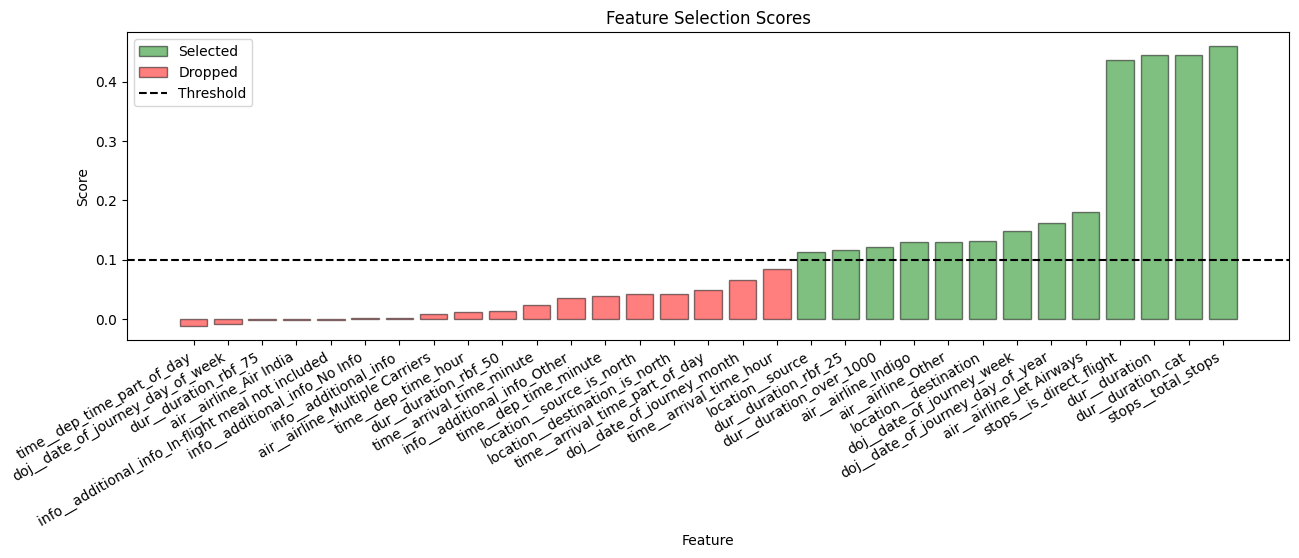

In [39]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()